## Import packages

In [1]:
import os
import cv2
import tqdm
import glob
import json
import requests
import numpy as np
from PIL import Image
from time import time
from scipy import signal
import matplotlib.pyplot as plt

import tensorflow as tf
import lucid.optvis.render as render
import lucid.modelzoo.vision_models as models
from keras.applications.inception_v3 import preprocess_input

# from args import *
# from constant import *
# from inceptionV1_helper import *
# from load_data import _parse_function

Using TensorFlow backend.


## Settings

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## Load InceptionV1

In [3]:
# Import InceptionV1 model
model = models.InceptionV1()
model.load_graphdef()

## Functions

In [135]:
def load_act_map(layer, imgs):

    with tf.Graph().as_default(), tf.Session():

        # Model render
        t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        T = render.import_model(model, t_input, t_input)

        # Activation map
        t_acts = T(layer)
        acts = t_acts.eval({t_input: imgs}) # [N, H, W, C]

    return acts


def get_prev_layer(layer):
    
    layers = [
        'mixed3a', 
        'mixed3b', 
        'mixed4a', 
        'mixed4b', 
        'mixed4c',
        'mixed4d',
        'mixed4e',
        'mixed5a',
        'mixed5b'
    ]
    layer_idx = layers.index(layer)
    if layer_idx == 0:
        return None
    else:
        return layers[layer_idx -1]
    
    
def get_t_blk(block):
    '''
    Get block tensor
    * input
        - block: the name of block (e.g., 'mixed3a', 'mixed3b_3x3')
    * output
        - t_block: the tensor of the block
    '''

    # The name of tensor of the given block
    block_name = 'import/%s' % block
    if ('_' in block) and (block[-2:] != '_w'):
        block_name += '_bottleneck'
    block_name += ':0'

    # Get the tensor
    t_block = tf.get_default_graph().get_tensor_by_name(block_name)

    return t_block
    

def get_input_blk(conn):
    
    layer, apdx = conn.split('_')
    prev_layer = get_prev_layer(layer)
    
    if apdx == 'concat0':
        return get_t_blk(prev_layer)
        
    elif apdx == 'concat1':
        return get_t_blk('{}_3x3'.format(layer))
        
    elif apdx == 'concat2':
        return get_t_blk('{}_5x5'.format(layer))
        
    elif apdx == 'concat3':
        return get_t_blk(prev_layer)
        
    elif apdx == 'conn3x3':
        return get_t_blk(prev_layer)
        
    elif apdx == 'conn5x5':
        return get_t_blk(prev_layer)
    
    
def get_weight_blk(conn):
    
    layer, apdx = conn.split('_')
    
    if apdx == 'concat0':
        return get_t_blk('{}_1x1_w'.format(layer))
        
    elif apdx == 'concat1':
        return get_t_blk('{}_3x3_w'.format(layer))
        
    elif apdx == 'concat2':
        return get_t_blk('{}_5x5_w'.format(layer))
        
    elif apdx == 'concat3':
        return get_t_blk('{}_pool_reduce_w'.format(layer))
        
    elif apdx == 'conn3x3':
        return get_t_blk('{}_3x3_bottleneck_w'.format(layer))
        
    elif apdx == 'conn5x5':
        return get_t_blk('{}_5x5_bottleneck_w'.format(layer))
    

def load_conn_act_map(conn):
    
    with tf.Graph().as_default(), tf.Session():
        
        t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        T = render.import_model(model, t_input, t_input)
        T('mixed3a')
        
        t_i = get_input_blk(conn)
        t_w = get_weight_blk(conn)
        t_conn = tf.nn.depthwise_conv2d(t_i, t_w, strides=[1, 1, 1, 1], padding='SAME')
        conn_data = t_conn.eval({t_input: [img]}) # [1, H, W, C]
        i_data = t_i.eval({t_input: [img]})
        w_data = t_w.eval({t_input: [img]})

    conn_data = conn_data[0]
    return conn_data, i_data, w_data
        

def load_act_threshold():
    dir_path = '../../data/InceptionV1/activation_threshold'
    file_path = '{}/act_thr-neuron-100-0.05.json'.format(dir_path)
    with open(file_path, 'r') as f:
        data = json.load(f)
    data = {key: float(data[key]) for key in data}
    return data


def get_blk_size(blk): 
    blk_sizes = {
        # mixed 3b
        'mixed3b_concat0': 128,
        'mixed3b_concat1': 192,
        'mixed3b_concat2': 96,
        'mixed3b_concat3': 64,
        'mixed3b_3x3': 128,
        'mixed3b_5x5': 32,
        # mixed 4a
        'mixed4a_concat0': 192,
        'mixed4a_concat1': 204,
        'mixed4a_concat2': 48,
        'mixed4a_concat3': 64,
        'mixed4a_3x3': 96,
        'mixed4a_5x5': 16,
        # mixed 4b
        'mixed4b_concat0': 160,
        'mixed4b_concat1': 224,
        'mixed4b_concat2': 64,
        'mixed4b_concat3': 64,
        'mixed4b_3x3': 112,
        'mixed4b_5x5': 24,
        # mixed 4c
        'mixed4c_concat0': 128,
        'mixed4c_concat1': 256,
        'mixed4c_concat2': 64,
        'mixed4c_concat3': 64,
        'mixed4c_3x3': 128,
        'mixed4c_5x5': 24,
        # mixed 4d
        'mixed4d_concat0': 112,
        'mixed4d_concat1': 288,
        'mixed4d_concat2': 64,
        'mixed4d_concat3': 64,
        'mixed4d_3x3': 144,
        'mixed4d_5x5': 32,
        # mixed 4e
        'mixed4e_concat0': 256,
        'mixed4e_concat1': 320,
        'mixed4e_concat2': 128,
        'mixed4e_concat3': 128,
        'mixed4e_3x3': 160,
        'mixed4e_5x5': 32,
        # mixed 5a
        'mixed5a_concat0': 256,
        'mixed5a_concat1': 320,
        'mixed5a_concat2': 128,
        'mixed5a_concat3': 128,
        'mixed5a_3x3': 160,
        'mixed5a_5x5': 48,
        # mixed 5b
        'mixed5b_concat0': 384,
        'mixed5b_concat1': 384,
        'mixed5b_concat2': 128,
        'mixed5b_concat3': 128,
        'mixed5b_3x3': 192,
        'mixed5b_5x5': 48
    }
    return blk_sizes[blk]

In [261]:
def crop_img(img):
    H, W, RGB = img.shape
    S = min(H, W)
    if H > W:
        cropped_img = img[:S, :S, :]
    else:
        cropped_img = img[:S, 150: S + 150, :]
    return cropped_img

## Load images

In [262]:
# Load an image
urls = [
#     'https://images.unsplash.com/photo-1534361960057-19889db9621e?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=2250&q=80',
    'https://images.unsplash.com/photo-1529429617124-95b109e86bb8?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=1275&q=80',
    'https://images.unsplash.com/photo-1609896372384-3902df4773fa?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=2167&q=80',
    'https://images.unsplash.com/photo-1543466835-00a7907e9de1?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=2167&q=80'
]

picked_urls = urls
picked_imgs = []
picked_preprocessed_imgs = []
for url in picked_urls:
    img = Image.open(requests.get(url, stream=True).raw)
    img = np.asarray(img, dtype="uint8")
    c_img = crop_img(img)
    p_img = cv2.resize(c_img, (224, 224))
    p_img = preprocess_input(p_img)
    picked_imgs.append(c_img)
    picked_preprocessed_imgs.append(p_img)

## Activation map

In [263]:
layer = 'mixed4c'
A = load_act_map(layer, picked_preprocessed_imgs)

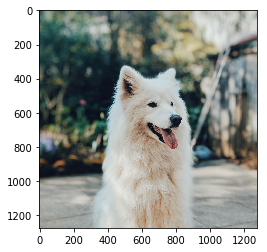

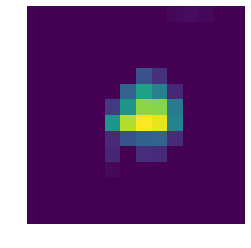

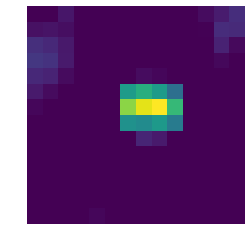

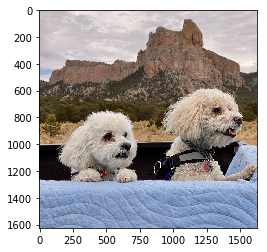

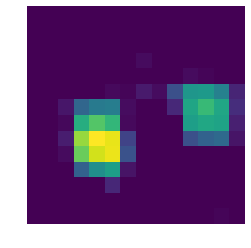

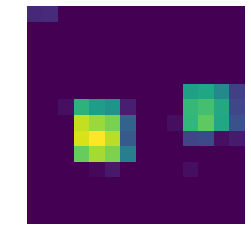

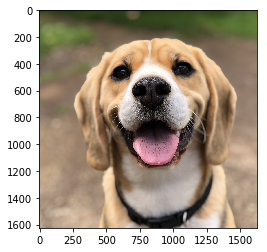

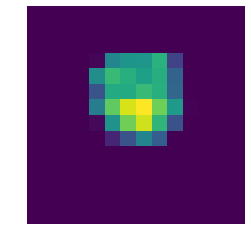

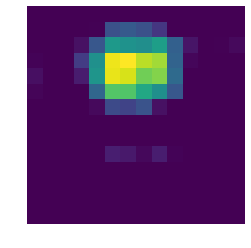

In [272]:
dir_path = '../../data/InceptionV1/example'
neurons = [460, 483]

for i, img in enumerate(picked_imgs):
    plt.imshow(img)
    plt.savefig('{}/ex-{}-img.png'.format(dir_path, i))
    plt.show()
    for neuron in neurons:
        plt.imshow(A[i, :, :, neuron])
        plt.axis('off')
        plt.savefig('{}/ex-{}-{}-{}.png'.format(dir_path, i, layer, neuron))
        plt.show()

## Connection

In [ ]:
# Conn
conn, i_data, w_data = load_conn_act_map('mixed4e_concat3')
neurons = [704]
input_conns = {}
for neuron in neurons:
    out_neuron_idx = neuron - 704
    input_conns[neuron] = get_all_cons_of_out_neuron(conn, 'mixed4e_concat3', out_neuron_idx)

In [ ]:
def get_all_cons_of_out_neuron(conn, out_blk, neuron):
    H, W, num_conn = conn.shape
    num_out = get_blk_size(out_blk)
    num_input = int(num_conn / num_out) 
    cons = np.zeros((num_input, H, W))
    for i in range(num_input):
        cons[i] = conn[:, :, num_out * i + neuron]
    return cons

In [ ]:
dd = {}
for neuron in neurons:
    high_input_neurons = np.argsort(-np.max(np.max(input_conns[neuron], axis=1), axis=1))[:20]
    print(high_input_neurons)
    for n in high_input_neurons:
        if n not in dd:
            dd[n] = 0
        dd[n] += 1
        
    
#     for input_neuron in high_input_neurons:
#         plt.title(input_neuron)
#         plt.imshow(input_conns[neuron][input_neuron, :, :])
#         plt.colorbar()
#         plt.show()
#     print('--------')

In [ ]:
for n in dd:
    if dd[n] == 2:
        print(n)

In [ ]:
plt.imshow(-conn[:, :, 521])
plt.colorbar()
plt.show()

## TF nodes

In [ ]:
with tf.Graph().as_default():
    t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
    T = render.import_model(model, t_input, t_input)
    T('mixed3a')
    nodes = tf.get_default_graph().as_graph_def().node

In [ ]:
nodes[6]

## Check example patches

In [ ]:
# Load activation map
layer = 'mixed4a'
with tf.Graph().as_default(), tf.Session():
    
    # Model render
    t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Activation map
    t_acts = T(layer)
    acts = t_acts.eval({t_input: [img]}) # [1, H, W, C]

acts = acts[0]

In [ ]:
# Check most activated neurons
most_activated_neurons = []
num_neurons = acts.shape[-1]
neuron_to_act = {}
for neuron in range(num_neurons):
    neuron_to_act[neuron] = np.max(acts[:, :, neuron])
most_activated_neurons = sorted(neuron_to_act, key=neuron_to_act.get, reverse=True)[:20]

In [ ]:
# Print most activated neurons in the layer
print(most_activated_neurons)

In [ ]:
# Load activation map
g = {}
with tf.Graph().as_default(), tf.Session():
    
    # Model render
    t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Activation map
    t_acts = T(layer)
    acts = t_acts.eval({t_input: [img]}) # [1, H, W, C]
    d, w, h, num_neurons = acts.shape
    
    # Tensor of gradients
    for neuron in most_activated_neurons:
        highest_idx = np.argmax(acts[0, :, :, neuron])
        r, c = highest_idx // w, highest_idx % w
        t_g = tf.gradients(t_acts[0, r, c, neuron], [t_input])
        g[neuron] = t_g[0].eval({t_input: [img]}) # [1, H, W, 3 for RGB]
    
acts = acts[0]

In [ ]:
# Function to find patch coord
def find_patch(gray_img):
    R, C = gray_img.shape
    r1, c1, r2, c2 = R - 1, C - 1, 0, 0
    thr = np.sort(gray_img.reshape(-1))[int(R * C * (1 - 0.03))]
    for r in range(R):
        for c in range(C):
            if gray_img[r, c] > thr:
                r1 = min(r1, r)
                c1 = min(c1, c)
                r2 = max(r2, r)
                c2 = max(r2, c)
    return r1, c1, r2, c2

In [ ]:
# Check the activation map of the most activated neurons
for neuron in most_activated_neurons:
    plt.title('{}-{}'.format(layer, neuron))
    plt.imshow(acts[:, :, neuron])
    plt.show()
    gray_g = cv2.cvtColor(g[neuron][0, :, :, :], cv2.COLOR_BGR2GRAY)
    gray_g = np.abs(cv2.cvtColor(g[neuron][0, :, :, :], cv2.COLOR_BGR2GRAY))
    r1, c1, r2, c2 = find_patch(gray_g)
    plt.imshow(gray_g)
    plt.show()
    plt.imshow(img[r1: r2, c1: c2, :])
    plt.show()

In [ ]:
# Load threshold
with open('../data/act_thr/act_thr-7x7.json', 'r') as f:
    thr = json.load(f)
thr = {blk: float(thr[blk]) for blk in thr}

In [ ]:
# Load activation map
layer = 'mixed4e'
with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer)
    # .eval({t_input: [img]}) # [1, W, H, C]
    
    g = tf.gradients(
        acts[0, 6, 6, 517], [t_input]
    )
    g = g[0].eval({t_input: [img]})
    
    acts = acts.eval({t_input: [img]}) # [1, W, H, C]

acts = acts[0]

In [ ]:
print(np.min(acts))
print(np.min(g), np.max(g))
# print(np.abs(g) > 1e-1)

In [ ]:
# g > 0
# g[g > 0] = 1

g[np.abs(g) > 1e-1] = 1
g[np.abs(g) <= 1e-1] = 0

In [ ]:
plt.imshow(g[0])
plt.colorbar()

In [ ]:
np.abs(-1)

In [ ]:
plt.title('gradient of {}-{}')
plt.imshow(g[0])

In [ ]:
neuron = 733
plt.imshow(acts[:, :, neuron])
plt.title('{}-{}'.format(layer, neuron))
plt.show()


resized = cv2.resize(acts[:, :, neuron], (7, 7), interpolation=cv2.INTER_LINEAR)
plt.imshow(resized)
plt.title('{}-{}'.format(layer, neuron))
plt.show()

In [ ]:
# Resize and threshold the activation map
resized = cv2.resize(acts, (7, 7), interpolation=cv2.INTER_LINEAR)
thresholded = (resized >= thr[layer]).astype(int)

In [ ]:
# Convolution
kernel_size = 2
kernel = np.ones((kernel_size, kernel_size))
conv_output, num_neurons = [], thresholded.shape[-1]
for neuron in range(num_neurons):
    conv_output_of_curr_neuron = signal.convolve2d(thresholded[:, :, neuron], kernel, 'valid')
    conv_output_of_curr_neuron = conv_output_of_curr_neuron.reshape(-1)
    conv_output.append(conv_output_of_curr_neuron)

## Minhash

In [ ]:
idxs = np.random.permutation(np.arange(7 * 7))
centers = [[idx // 7, idx % 7] for idx in idxs]

z = np.zeros((7, 7))
for c in centers:
    z[c] = 1
z[1:3, 2:9]

In [ ]:
l = [False, False, False, False]
t = 0
for _ in range(10000):
    tic = time()
    np.sum(l)
    toc = time()
    t += toc - tic
print(t)

In [ ]:
t = 0
for _ in range(10000):
    tic = time()
    any(l)
    toc = time()
    t += toc - tic
print(t)

## Jaccard sim test

In [ ]:
tic = time()
a = np.zeros((14, 14))
b = np.ones((14, 14))
for i in range(300 * 500):
    
    OR = a + b
    AND = np.matmul(a, b)
    
    
toc = time()
print('10%%: %.2lf sec' % (toc - tic))

In [ ]:
0.54 * 1300 * 10 / 60 / 60 